<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN_masses_vs_calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **masses and calcification**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*

## Data Loading
This can be easily done with the Python data manipulation. Modern deep learning provides a very powerful framework for supervised learning, we introduce on this step the convolutional network for scaling to large images.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers
from keras import optimizers 
from keras import models
from keras import regularizers

BATCH_SIZE = 20
EPOCHS = 100

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

print("Done")

Done


In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


In [ ]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

# Visualization Data Histogram
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt


print("Done")

Done


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


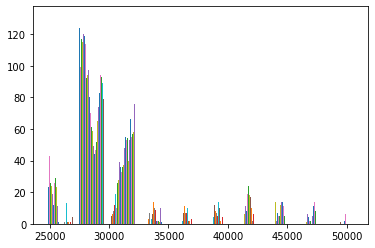

In [ ]:
# Check the value range and the distribution
plt.hist(train_images[0]) 
plt.show()

In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


## Data preprocessing

Computer vision usually requires relatively little of this kind of preprocessing. The images should be standardized, formatting images to have the same scale is the only kind of preprocessing that is strictly necessary. As optional, we add dataset augmentation because is an excellent way to reduce the generalization error of most computer vision models.

In [ ]:
# Split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.7*len(train_images))]
valid_images_split = train_images[int(0.7*len(train_images)):]
train_labels_split = train_labels[:int(0.7*len(train_labels))]
valid_labels_split = train_labels[int(0.7*len(train_labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(1873, 150, 150, 1)
(803, 150, 150, 1)


In [ ]:
# Verify values range: 
# Getting max value 
max = max([np.max(image) for image in train_images]) # max is 65535 

# Getting min value 
min = min([np.min(image) for image in train_images]) # min is 0

print("Original tensor are of type ", train_images[0].dtype, " with values in the range [", min,",", max, "]")

Original tensor are of type  uint16  with values in the range [ 0 , 65535 ]


In [ ]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 1)
(20,)


### Defining CNN 


In [ ]:
def build_model(loss_function, eval_metric):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  #model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=["acc"]) 
  
  return model 

print("Done")

Done


### CNN Compilation



In [ ]:
model = build_model("binary_crossentropy", "acc")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 10s 26ms/step - loss: 1.4299 - acc: 0.5381 - val_loss: 1.0436 - val_acc: 0.5512
Epoch 2/100
93/93 [==============================] - 2s 20ms/step - loss: 0.9752 - acc: 0.5685 - val_loss: 0.8028 - val_acc: 0.7225
Epoch 3/100
93/93 [==============================] - 2s 20ms/step - loss: 0.7698 - acc: 0.6484 - val_loss: 0.6462 - val_acc: 0.7575
Epoch 4/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6334 - acc: 0.7555 - val_loss: 0.5706 - val_acc: 0.8188
Epoch 5/100
93/93 [==============================] - 2s 20ms/step - loss: 0.6008 - acc: 0.7790 - val_loss: 0.6677 - val_acc: 0.6488
Epoch 6/100
93/93 [==============================] - 2s 20ms/step - loss: 0.5481 - acc: 0.7891 - val_loss: 0.5457 - val_acc: 0.8250
Epoch 7/100
93/93 [==============================] - 2s 20ms/step - loss: 0.5375 - acc: 0.8034 - val_loss: 0.5149 - val_acc: 0.8288
Epoch 8/100
93/93 [==============================] - 2s 20ms/step - loss: 0

### Visualizing The Data

One way to do this is by looking at the distribution of some of the dataset’s variables and make scatter plots to see possible correlations. 

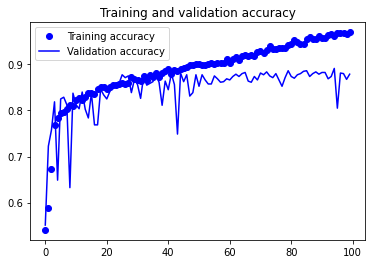

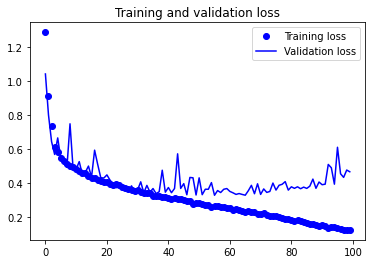

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])

print("Accuracy:", "%0.2f" % (test_acc*100), "%")

16/16 [==============================] - 0s 8ms/step - loss: 0.6427 - acc: 0.8406
Accuracy: 84.06 %


### Fighting overfitting: 1. Data Augmentation

Neural networks prove not to be very robust to noise, and these plots are characteristic of **overfitting**. Training accuracy keeps increasing linearly while validation accuracy stalls around **82%**. 



In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [ ]:
# Building the new model with the train data augmentation
model = build_model("binary_crossentropy", "acc")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 5s 49ms/step - loss: 1.4353 - acc: 0.5186 - val_loss: 1.0401 - val_acc: 0.5512
Epoch 2/100
93/93 [==============================] - 4s 46ms/step - loss: 0.9636 - acc: 0.5573 - val_loss: 0.7883 - val_acc: 0.5512
Epoch 3/100
93/93 [==============================] - 4s 46ms/step - loss: 0.7651 - acc: 0.5813 - val_loss: 0.6705 - val_acc: 0.6725
Epoch 4/100
93/93 [==============================] - 4s 46ms/step - loss: 0.6835 - acc: 0.6883 - val_loss: 0.6764 - val_acc: 0.5800
Epoch 5/100
93/93 [==============================] - 4s 46ms/step - loss: 0.6413 - acc: 0.7000 - val_loss: 0.5586 - val_acc: 0.7975
Epoch 6/100
93/93 [==============================] - 4s 45ms/step - loss: 0.6036 - acc: 0.7321 - val_loss: 0.4957 - val_acc: 0.7987
Epoch 7/100
93/93 [==============================] - 4s 46ms/step - loss: 0.5786 - acc: 0.7559 - val_loss: 0.4881 - val_acc: 0.8138
Epoch 8/100
93/93 [==============================] - 4s 47ms/step - loss: 0.

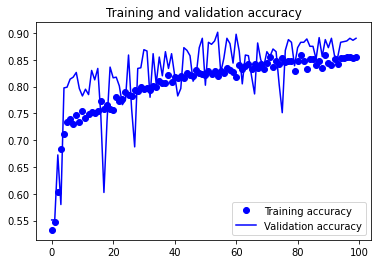

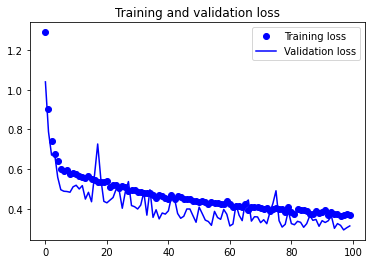

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])

print("Accuracy:", "%0.2f" % (test_acc*100), "%")

16/16 [==============================] - 0s 8ms/step - loss: 0.3553 - acc: 0.8438
Accuracy: 84.38 %


##K-fold cross validation.


In [ ]:
# Train data augmentation for k-fold-cross-validation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
print(train_images.shape)

(2676, 150, 150, 1)


In [ ]:
def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []

  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model("binary_crossentropy", "acc")
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity,
                        callbacks=[GarbageCollectorCallback()])
    
    val_loss, val_acc = model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                       steps=len(validation_data) // batch_size,
                                       callbacks=[GarbageCollectorCallback()])
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)

  return validation_accuracies, validation_losses 
  
print("Done")

Done


In [ ]:
acc, loss = cross_validate(k=10, batch_size=20, num_epochs=100, dataset=train_images, targets=train_labels, verbosity=1)

In [ ]:
print(len(acc))
print(len(loss))
print()
print(np.mean(acc))
print(np.mean(loss))

### Hyperparameters Tuning

To compare the performance of one machine learning algorithm to another, it is necessary to perform controlled experiments

*   add Dropout or L2 Regularization
*   varying of convolutional layers: [3, 5, 7]
*   varying # of units per layer:

| Layer  | Unit per Layer  |  
|---|---|
| 1  | [32,32,64,128]  |
| 2  | [32,64,128,128]  |
| 3  | [32,64,128,256]  |
| 4  | [64,64,128,256]  |

*   change Optimizer (try Adam)
*   varying batch size: [20, 32, 64, 128]
*   varying learning rate 



In [ ]:
#Parameters Grid 
dropout_regularization = True                                               # grafico comparativo: sembra leggermente meglio con Dropout
batch_sizes = [20, 32, 64, 128]                                             # 4 
layers_number = 4                                                           # 1
units_per_layer_dict = [[32,64,128,128], [32,64,128,256]]                   # 2
learning_rates = [1e-2, 1e-3, 1e-4]                                         # 3
num_epochs = 100
num_folds = 5

file_path_out = os.path.join(base_path, "tuning results/top3_results.csv")
file_path = os.path.join(base_path, "tuning results/results_full.csv")
model_path = os.path.join(base_path, "tuning results/best_model.h5")

# Top k models 
k = 3

In [ ]:
def build_custom_model(layers_number, units_per_layer, batch_size, dropout, optimizer):
  model = models.Sequential()

  for i in range(layers_number):
     # First layer. Setting input shape
    if i == 0: 
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu', input_shape=(150, 150, 1)))
      model.add(layers.MaxPooling2D((2, 2)))
    else:
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu'))
      model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  
  if dropout:
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["acc"]) 
  
  return model 

def CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_reg, dataset, targets):
  lr = learning_rates[0]
  opts = [optimizers.RMSprop(lr=lr), optimizers.Adam(learning_rate=lr)]

  with open(file_path, 'w') as f:
    header = "batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,mean_val_loss,num_folds\n"
    f.write(header)

  for batch_size in batch_sizes:                # 4
    for opt in opts:                            # 2
      for values_set in units_per_layer_dict:   # 2
        # Build CNN model 
        model = build_custom_model(layers_number, values_set, batch_size, dropout_reg, opt)

        if "RMSprop" in str(opt):
          str_opt = "RMSprop"  
        else:
          str_opt = "Adam"

        #print info 
        print("-----------------------------------------------------")
        print("batch_size: \t", batch_size)
        print("num_epochs: \t", num_epochs)
        print("units_per_layer:", str(values_set).replace(",", " "))
        print("optimizer: \t", str_opt)
        print("learning_rate: \t", str(lr))
        print("num_folds CV: \t", num_folds)
        print("-----------------------------------------------------")

        #cross validate CNN model
        val_acc, val_loss = cross_validate(num_folds, batch_size, num_epochs, dataset, targets, 1)

        #save results on csv file 
        with open(file_path, 'a') as f:
          row = str(batch_size) + "," \
              + str(num_epochs) + "," \
              + str(values_set).replace(",", " ") + "," \
              + str_opt + "," \
              + str(lr) + "," \
              + "%0.4f (+/- %0.4f)" % (np.mean(val_acc), np.std(val_acc) * 2) + "," \
              + "%0.4f (+/- %0.4f)" % (np.mean(val_loss), np.std(val_loss) * 2) + "," \
              + str(num_folds) + "\n"
          f.write(row)

        del model
        K.clear_session()

print("Done")

Done


In [ ]:
CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_regularization, train_images, train_labels)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 55/100
107/107 [==============================] - 5s 44ms/step - loss: 0.4123 - acc: 0.8387
Epoch 56/100
107/107 [==============================] - 5s 44ms/step - loss: 0.4143 - acc: 0.8260
Epoch 57/100
107/107 [==============================] - 5s 43ms/step - loss: 0.4336 - acc: 0.8214
Epoch 58/100
107/107 [==============================] - 5s 44ms/step - loss: 0.3993 - acc: 0.8322
Epoch 59/100
107/107 [==============================] - 5s 44ms/step - loss: 0.4096 - acc: 0.8206
Epoch 60/100
107/107 [==============================] - 5s 44ms/step - loss: 0.4006 - acc: 0.8524
Epoch 61/100
107/107 [==============================] - 5s 44ms/step - loss: 0.3946 - acc: 0.8490
Epoch 62/100
107/107 [==============================] - 5s 44ms/step - loss: 0.4017 - acc: 0.8247
Epoch 63/100
107/107 [==============================] - 5s 44ms/step - loss: 0.3876 - acc: 0.8328
Epoch 64/100
107/107 [==============================] - 5

KeyboardInterrupt: ignored

##Testing best k models: 
feeding the models with all available data and evaluating these one last time on the test set.

In [ ]:
# Full training set non-splitted 
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2676, 150, 150, 1)
(2676,)
(336, 150, 150, 1)
(336,)


In [ ]:
def evaluate_best_model(k, file_path, file_path_out):
  # Load results  
  data = pd.read_csv(file_path)

  # Sort results by accuracies 
  data.sort_values(by=['mean_val_acc'], ascending=False, inplace=True)
  data.head()

  # Init variables
  layers_number = 4
  batch_size = 0
  num_epochs = 0
  units_per_layer = []
  optimizer = 0
  learning_rate = 0
  dropout=True

  with open(file_path_out, 'w') as f:
    header = "batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,mean_val_loss,prediction_acc\n"
    f.write(header)

  # Get parameters values
  for index, row in data[:k].iterrows():

    #print info 
    print("-----------------------------------------------------")
    print("batch_size: \t", str(row["batch_size"]))
    print("num_epochs: \t", str(row["num_epochs"]))
    print("units_per_layer:", str(row["units_per_layer"]))
    print("optimizer: \t", str(row["optimizer"]))
    print("learning_rate: \t", str(row["learning_rate"]))
    print("mean_val_acc: \t", str(row["mean_val_acc"]))
    print("mean_val_loss: \t", str(row["mean_val_loss"]))
    print("-----------------------------------------------------")


    batch_size = int(row["batch_size"])
    num_epochs = int(row["num_epochs"])
    units_per_layer = ast.literal_eval(row["units_per_layer"].replace("  ", ","))
    optimizer = row["optimizer"]
    learning_rate = row["learning_rate"]

    if optimizer == "Adam":
      opt = optimizers.Adam(learning_rate=float(learning_rate))
    else: 
      opt = optimizers.RMSprop(learning_rate=float(learning_rate))

    # Build model
    model = build_custom_model(layers_number, units_per_layer, batch_size, dropout, opt)

    # Fit model on all the available data
    history = model.fit(train_datagen.flow(train_images, 
                                          train_labels,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(train_images) // batch_size,
                        callbacks=[GarbageCollectorCallback()])
    
    # Evaluate model on test set 
    test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                        test_labels,
                                                        batch_size=batch_size,
                                                        shuffle=False),
                                        steps=len(test_images) // batch_size,
                                        callbacks=[GarbageCollectorCallback()])

    print("Accuracy:", "%0.2f" % (test_acc*100), "%")

    # Get the prediction for each sample
    predictions = model.predict(
      test_images,
      max_queue_size=10,
      callbacks=[GarbageCollectorCallback()]) 
    
    predicted = np.argmax(predictions,axis=1) 

    correct_predictions = np.sum(np.equal(predicted,test_labels))
    accuracy = correct_predictions/len(test_labels)
    print("\n-----------------------------------------------------")
    print("Correct Predictions")
    print("Accuracy:", "%0.2f" % (accuracy*100), "%")
    print("-----------------------------------------------------\n")

    if index == 0:
      model.save(model_path)

    # Save results on csv file 
    with open(file_path_out, 'a') as f:
      row = str(row["batch_size"]) + "," \
          + str(row["num_epochs"]) + "," \
          + str(row["units_per_layer"]) + "," \
          + str(row["optimizer"]) + "," \
          + str(row["learning_rate"]) + "," \
          + str("%0.4f" % (test_acc)) + "," \
          + str("%0.4f" % (test_loss)) + "," \
          + str(accuracy) + "\n"
      f.write(row)

print("Done")

Done


In [ ]:
data[:k].head()

In [ ]:
# Get from file the a list of models and evaluate the best
evaluate_best_model(k, file_path, file_path_out)

-----------------------------------------------------
batch_size: 	 20
num_epochs: 	 100
units_per_layer: [32  64  128  256]
optimizer: 	 RMSprop
learning_rate: 	 0.001
mean_val_acc: 	 0.8865
mean_val_loss: 	 0.3096 (+/- 0.0342)
-----------------------------------------------------
Epoch 1/100
133/133 [==============================] - 12s 38ms/step - loss: 0.7660 - acc: 0.5363
Epoch 2/100
133/133 [==============================] - 5s 38ms/step - loss: 0.6989 - acc: 0.5430
Epoch 3/100
133/133 [==============================] - 5s 39ms/step - loss: 0.6929 - acc: 0.5282
Epoch 4/100
133/133 [==============================] - 5s 39ms/step - loss: 0.6911 - acc: 0.5373
Epoch 5/100
133/133 [==============================] - 5s 39ms/step - loss: 0.6927 - acc: 0.5460
Epoch 6/100
133/133 [==============================] - 5s 38ms/step - loss: 0.6894 - acc: 0.5552
Epoch 7/100
133/133 [==============================] - 5s 38ms/step - loss: 0.6926 - acc: 0.5569
Epoch 8/100
133/133 [================

In [ ]:
# Get the prediction for each sample
model = load_model(model_path)


OSError: ignored

In [ ]:

predictions = model.predict(
  test_images,
  max_queue_size=10,
  callbacks=[GarbageCollectorCallback()]) 

predicted = np.argmax(predictions,axis=1) 

correct_predictions = np.sum(np.equal(predicted,test_labels))
accuracy = correct_predictions/len(test_labels)


# try to load the model again

test_loss, test_acc = model.evaluate(test_images,test_labels)

print('test_acc:', test_acc)

## Reference


>**Student** | **Email contact**
>--- | ---
>A. Schiavo | a.schiavo2@studenti.unipi.it
>M. Gómez	|	m.gomezgomez@studenti.unipi.it
>M. Daole |	m.daole@studenti.unipi.it
